# Objectif : 
Ce notebook a pour but de **contrôler la correcte applicaiton des règles métiers** sur les jeux de données fournis par le courtier dans le cadre du reporting mensuel.

# Datasets :
- Contrats
- Quittances
- Sinistres
- Tarifs

# Étapes :
1. Contrôle des doublons
2. Imaginer les erreurs potentielles / Contrôle de cohérence
3. Contrôle de l'application du tarif
4. Contrôle des règles de gestion
5. Listing des anomalies

In [1]:
import os
import re
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("../scripts")
from checker import * 
from utils import * 

In [2]:
# Dossier contenant les données nettoyées
folder_path = "../data/processed"

# Mapping entre parties du nom de fichier et noms de variables souhaités
file_mapping = {
    "contrats": "df_contrats",
    "quittances": "df_quittances",
    "sinistres": "df_sinistres",
    "tarif": "df_tarifs"
}

# Chargement des fichiers Parquet
dataset = load_files_parquet(folder_path=folder_path, file_mapping=file_mapping)  # type: ignore

# Unpack
df_contrats = dataset["df_contrats"]
df_quittances = dataset["df_quittances"]
df_sinistres = dataset["df_sinistres"]
df_tarifs = dataset["df_tarifs"]

# Afficher l'ensemble des colonnes sans ellipses
pd.set_option('display.max_columns', None)

✅ Chargé : df_sinistres.parquet --> dataset['df_sinistres']
✅ Chargé : df_tarifs.parquet --> dataset['df_tarifs']
✅ Chargé : df_quittances.parquet --> dataset['df_quittances']
✅ Chargé : df_contrats.parquet --> dataset['df_contrats']


# 1. Contrôle des doublons / Clés primaires / Formats ID


1. Contrôle de la bijectivité de `coverRef` et `coverId`
2. Contrôle des doublons
3. Contrôle de l'uniformité des formats d'ID

In [3]:
#Contrôle relation 1:1 coverID / coverRef
df_anomalies_coverId = check_bijectivity_between_columns( # type: ignore
    df_contrats, 
    col_a="coverId", 
    col_b="coverRef", 
    anomaly_label="coverId_multiple_coverRef"
)

# Export si anomalie détectée
if not df_anomalies_coverId.empty:
    df_anomalies_coverId.to_csv("../outputs/anomalies_coverID_multiple_coverRef.csv", index=False)


🔍 Vérification de la bijectivité entre coverId et coverRef...
Nb de coverId associés à plusieurs coverRef : 1
⚠️ La relation coverId → coverRef n'est PAS bijective.
Nb de coverRef associés à plusieurs coverId : 0
✅ La relation coverRef → coverId est bijective (1:1).


On en déduit les clés : 
- Contrats : 
    - PK : `coverRef` (référence de contrat d'un animal assuré)
- Quittances : 
    - PK : `receiptId` (paiement mensuel d'un contrat)
    - FK : `df_contrats`.`coverRef`
- Sinistres : 
    - PK : combinaison (`incidentId`, `actId`) 
        - *NB : hypothèse - séquence sur les actesId*
    - FK : `df_contrats`.`coverRef`
- Tarifs : 
    - PK : Incorrecte / combinaison (`animal`, `age`, `couverture`)
        - *NB : hypothèse - clé étrangère manquante, ou PetRace*

In [4]:
primary_keys = {
    "df_contrats": ["coverId"],
    "df_quittances": ["receiptId"],
    "df_sinistres": ["actId", "incidentId"],
    "df_tarifs": ["animal", "age", "couverture"]
}

duplicates_report = check_all_duplicates_with_keys(dataset, primary_keys=primary_keys) # type: ignore


🔍 df_sinistres : détection des doublons
➡️ 1 doublons complets détectés.


,actDescription,claimPaid,notificationDate,guarantee,claimOutstanding,actDate,actCategory,coverRef,coverId,actType,actId,incidentId,actValue,incidentDate
130,[],12.24,2021-12-22 14:26:01.956301,0,0,2021-12-20,ACCIDENT,sub_1K2z9JF5i98BakySUuC2Y9yl-250268502090843,Sub_DLM_1552191-0,PHAR,C_qrtodl08_4,C_qrtodl08,15.3,2021-12-17
131,[],12.24,2021-12-22 14:26:01.956301,0,0,2021-12-20,ACCIDENT,sub_1K2z9JF5i98BakySUuC2Y9yl-250268502090843,Sub_DLM_1552191-0,PHAR,C_qrtodl08_4,C_qrtodl08,15.3,2021-12-17


⚠️ Affichage limité à 10 lignes pour les doublons complets.

➡️ 1 violations de la clé primaire ['actId', 'incidentId'].


,actDescription,claimPaid,notificationDate,guarantee,claimOutstanding,actDate,actCategory,coverRef,coverId,actType,actId,incidentId,actValue,incidentDate
130,[],12.24,2021-12-22 14:26:01.956301,0,0,2021-12-20,ACCIDENT,sub_1K2z9JF5i98BakySUuC2Y9yl-250268502090843,Sub_DLM_1552191-0,PHAR,C_qrtodl08_4,C_qrtodl08,15.3,2021-12-17
131,[],12.24,2021-12-22 14:26:01.956301,0,0,2021-12-20,ACCIDENT,sub_1K2z9JF5i98BakySUuC2Y9yl-250268502090843,Sub_DLM_1552191-0,PHAR,C_qrtodl08_4,C_qrtodl08,15.3,2021-12-17


⚠️ Affichage limité à 10 lignes pour les violations de clé primaire.

------------------------------------------------------------

🔍 df_tarifs : détection des doublons
➡️ 0 doublons complets détectés.
✅ Aucun doublon complet détecté.

➡️ 702 violations de la clé primaire ['animal', 'age', 'couverture'].


,animal,age,couverture,taux,healthLimit,franchise,healthHthcMonthly
1,cat,0,Accident,0.6,1000,0,6.78
19,cat,0,Accident,0.7,1000,0,8.02
37,cat,0,Accident,0.8,1000,0,9.28
55,cat,0,Accident,0.9,1000,0,10.55
73,cat,0,Accident,1.0,1000,0,11.83
91,cat,0,Accident,0.6,1200,0,7.56
109,cat,0,Accident,0.7,1200,0,8.99
127,cat,0,Accident,0.8,1200,0,10.43
145,cat,0,Accident,0.9,1200,0,11.90
163,cat,0,Accident,1.0,1200,0,13.38


⚠️ Affichage limité à 10 lignes pour les violations de clé primaire.

------------------------------------------------------------

🔍 df_quittances : détection des doublons
➡️ 0 doublons complets détectés.
✅ Aucun doublon complet détecté.

➡️ 0 violations de la clé primaire ['receiptId'].
✅ Aucun doublon sur la clé primaire.

------------------------------------------------------------

🔍 df_contrats : détection des doublons
➡️ 0 doublons complets détectés.
✅ Aucun doublon complet détecté.

➡️ 1 violations de la clé primaire ['coverId'].


,healthPremiumInclTax,preventionTax,healthBrokerFee,preventionPremiumInclTax,coverRef,petRace,liabilityCovered,coverEndDate,coverRate,petSick,petUuidType,petUuid,petType,petOwnerBirthday,coverId,healthLimit,preventionBrokerFee,preventionHthc,petOwnerName,coverStartDate,preventionLimit,healthHthc,petSex,healthTax,petBirthday,petName,petOwnerAddress,petOldDiseases,deductibleLimit,customerId
669,193.45,8.88,32.04,108.0,sub_K0aryWqH87FdhH-250268502141316,ragdoll,False,2022-09-08,0.8,healthy,chip,250268502141316,cat,1960-01-31,Sub_1817512-0,1500,-0.84,99.96,xxx,2021-09-08,100,144.00,MALE,17.410549,2021-04-01,Cléopâtre,xxxFrance,[],0,Cus_1168464
800,374.90,8.88,116.52,108.0,sub_K6wP0rlfZtLZBi-250269810316536,mixed_breed,False,2022-08-26,0.6,healthy,chip,250269810316536,dog,1973-02-07,Sub_1817512-0,1500,-0.84,99.96,xxx,2021-08-26,100,224.64,FEMALE,33.741099,2013-10-01,Cléopâtre,xxxFrance,[],0,Cus_1682219


⚠️ Affichage limité à 10 lignes pour les violations de clé primaire.

------------------------------------------------------------



In [5]:
anomalies_global = scan_all_datasets_for_id_anomalies(dataset) # type: ignore


🔍 Analyse du dataset : df_sinistres

🔍 Analyse du dataset : df_tarifs

🔍 Analyse du dataset : df_quittances

🔍 Analyse du dataset : df_contrats

🆔 Analyse de la colonne 'petUuid'
🔍 Nombre de valeurs entièrement alphabétiques : 7
⚠️ Exemples de valeurs suspectes :
['chip']

✅ Anomalies globales exportées vers 'anomalies_ids_format_global.csv'


In [6]:
#contrôle des trous de séquence (acteId) sur df_sinistres

# 2. Contrôles de cohérence 

In [7]:
run_all_consistency_checks(df_contrats, df_quittances, df_sinistres)# type: ignore


========== 📄 LANCEMENT DES CONTRÔLES DE COHÉRENCE ==========

🔹 1. Contrats sans quittance
[check_contracts_have_quittance] Nombre de contrats sans quittance détectés : 2
[check_contracts_have_quittance] Nombre de coverRef distincts concernés : 2
[check_contracts_have_quittance] Montant total des primes concernées : 383.97 €
[check_contracts_have_quittance] coverRefs concernés : ['sub_JPvnlDW8nBmHjP-250269608337058', 'sub_K0aryWqH87FdhH-250268502141316']
------------------------------------------------------------

🔹 2. Quittances sans contrat
[check_quittance_have_matching_contracts] Nombre de Quittances en Anomalies détectées : 10
[check_quittance_have_matching_contracts] Nombre de coverRef distincts sans contrat : 7
[check_quittance_have_matching_contracts] Total Primes des quittances concernées : 235.90 €
[check_quittance_have_matching_contracts] coverRef concernés : ['sub_1JrMc4F5i98BakyS905SV9sR-250268732548727', 'sub_1JnK6fF5i98BakySZFBryTyk-25026872004422', 'sub_JzTgPvMcxdPfrx

# Règles métiers

In [8]:
results_part1, anomalies_part1 = run_quality_pipeline_part1(df_contrats, df_quittances, df_tarifs)



========== 📋 LANCEMENT DU PIPELINE QUALITÉ CONTRATS — PARTIE 1 ==========

🔹 1. Durée des contrats — Vérifie que chaque contrat dure exactement 1 an
[check_contract_duration] Nombre de contrats avec durée ≠ 1 an : 3
[check_contract_duration] Nombre de coverRef concernés : 3
[check_contract_duration] coverRefs concernés : ['sub_KCBrp1lZVfGMEg-250268600336306', 'sub_1JeygtF5i98BakySXfQNEGzc-250269300150647', 'sub_1K4oMKF5i98BakySZtKVfBoK-250269590673101']

🔹 2. Éligibilité des animaux — Vérifie l'âge, la présence et le format du numéro d'identification
[check_eligibilite_animaux] Nombre d’animaux non éligibles : 255
[check_eligibilite_animaux] Nombre de customerId distincts concernés : 255
[check_eligibilite_animaux] coverRefs concernés : ['sub_JSTA6dBG7fvUQA-250268731585060', 'sub_JSWB8mIMvWdQ9s-250268743652706', 'sub_JSXmjsVvWxRMgP-250268731492607', 'sub_JVAKExJcCr9pWZ-250268731355558', 'sub_JY8TI8whGXhEeH-900108001316034', 'sub_JZD3fXFI7akdCO-250269590327490', 'sub_JZIK5X8JtepTua-234

In [9]:
results, anomalies = run_quality_pipeline_part2(df_contrats, df_quittances, df_sinistres, results_part1, anomalies_part1)




========== 📋 SUITE DU PIPELINE QUALITÉ CONTRATS — PARTIE 2 ==========

🔹 7. Dépassement des plafonds — Vérifie que les remboursements ne dépassent pas les limites prévues au contrat
[check_reimbursement_limits_with_contracts] ⚠️ 3 dépassement(s) détecté(s)

🔹 8. Taux de remboursement — Vérifie que claimPaid = actValue * coverRate pour certaines catégories d’actes
[check_taux_remboursement] Nombre d’anomalies de remboursement : 78
[check_taux_remboursement] Nombre de coverRefs concernés : 44

🔹 9. Délai de carence — Vérifie que les remboursements ont lieu après les délais de carence contractuels
[check_delai_carence] Nombre d’anomalies de carence détectées : 480
[check_delai_carence] Nombre de coverRefs concernés : 129

🔹 10. Valeurs négatives — Vérifie qu’aucune valeur numérique n’est strictement négative dans les jeux de données

🔎 Contrôle des valeurs négatives dans 'df_contrats'
⚠️  preventionBrokerFee contient 2149 valeur(s) négative(s)
    Exemples : [-0.84, -0.84, -0.84, -0.84, 

In [10]:
export_pipeline_anomalies(anomalies)


📤 Export des anomalies détectées :
🟠 Exporté : ../outputs/anomalies_contract_duration.csv
🟠 Exporté : ../outputs/anomalies_eligibilite_animaux.csv
🟢 Aucun problème détecté → anomalies_tarif_prevention.csv
🟢 Aucun problème détecté → anomalies_tarif_health.csv
🟠 Exporté : ../outputs/anomalies_arithmetique_contrats.csv
🟠 Exporté : ../outputs/anomalies_arithmetique_quittances.csv
🟠 Exporté : ../outputs/anomalies_plafond_remboursement.csv
🟠 Exporté : ../outputs/anomalies_taux_remboursement.csv
🟠 Exporté : ../outputs/anomalies_delai_carence.csv
🟠 Exporté : ../outputs/anomalies_valeurs_negatives.csv

========== ✅ EXPORT TERMINÉ ==========


# Synthèse des anomalies

In [11]:
df_recap_anomalies = export_all_anomalies_to_excel("../outputs", "../outputs/anomalies_report.xlsx")# type: ignore
display(df_recap_anomalies) 

✅ Exporté : anomalies_plafond_remboursement.csv → feuille 'plafond_remboursement'
✅ Exporté : anomalies_taux_remboursement.csv → feuille 'taux_remboursement'
✅ Exporté : anomalies_sinistres_sans_contrat.csv → feuille 'sinistres_sans_contrat'
✅ Exporté : anomalies_cleaning.csv → feuille 'cleaning'
✅ Exporté : anomalies_arithmetique_contrats.csv → feuille 'arithmetique_contrats'
✅ Exporté : anomalies_contract_duration.csv → feuille 'contract_duration'
✅ Exporté : anomalies_eligibilite_animaux.csv → feuille 'eligibilite_animaux'
✅ Exporté : anomalies_coverID_multiple_coverRef.csv → feuille 'coverID_multiple_coverRef'
✅ Exporté : anomalies_valeurs_negatives.csv → feuille 'valeurs_negatives'
✅ Exporté : anomalies_contrats_sans_quittance.csv → feuille 'contrats_sans_quittance'
✅ Exporté : anomalies_arithmetique_quittances.csv → feuille 'arithmetique_quittances'
✅ Exporté : anomalies_quittances_sans_contrat.csv → feuille 'quittances_sans_contrat'
✅ Exporté : anomalies_ids_format_global.csv → 

,Type d'anomalie,Nb de lignes,Nb de contrats uniques,Montant total concerné (€),Agrégat concerné
0,plafond_remboursement,3,3,1478.5,totalClaimPaid
1,taux_remboursement,78,44,5916.24,claimPaid
2,sinistres_sans_contrat,6,2,197.5,claimPaid
3,cleaning,172,-,-,-
4,arithmetique_contrats,1,1,511.16,healthPremiumInclTax
5,contract_duration,3,3,825.26,healthPremiumInclTax
6,eligibilite_animaux,255,255,97354.28,healthPremiumInclTax
7,coverID_multiple_coverRef,2,2,568.35,healthPremiumInclTax
8,valeurs_negatives,8531,2158,-308.4,claimPaid
9,contrats_sans_quittance,2,2,383.97,healthPremiumInclTax


/Users/guilhemberthou/happypet-data-quality/notebooks/../scripts/checker.py:1103: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bubble[montant_col].replace("-", np.nan).astype(float)


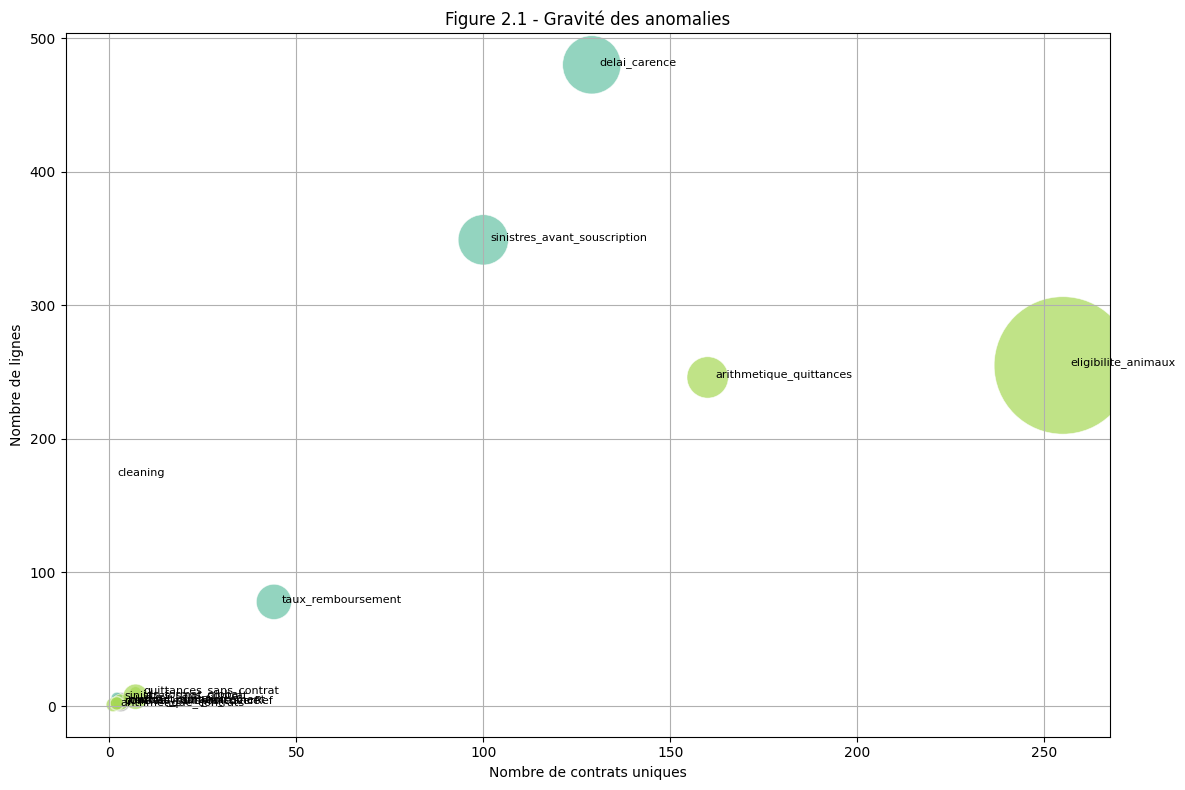

In [12]:
plot_bubble_anomalies(df_recap_anomalies, anomalies_a_exclure=["valeurs_negatives"])

# Conclusion

Compte tenu du nombre d'anomalie relevées, une seconde itération avec le courtier après une première correction des données pourrait être bénéfique. 

En dehors des anomalies listées dans le `report.xlsx`, les points suivants sont notables : 

- df_tarifs : 
    - La Garantie Health couvre les soins de Maladie et d'Accident : or la table tarif ne contient qu'Accident dans la colonne couverture
    - Table inexploitable : pour un type d'animal, et un âge, plusieurs montant de prime, taux de couverte sont listés sans possibilité de distinguer la police associée (clé étrangère manquante, ou PetRace)
    
- df_quittance : 
    - Hypothèse : Guarantee = claimPaid + claimOutstanding. Guarantee est nul -> A VENTILER pour suivre le montant total restant

- df_contrats : 
    - eligibilité des animaux : absence d'information sur la formule pour choix de l'âge maximal couvert (*"7 ou 9 ans selon la formule choisie à l'adhésion"*)
    - reconduction / résiliation : sauf erreur, nous n'avons pas d'information sur la date de résiliation. Nous avons donc considéré que les contrats s'étaient tacitement reconduits. 

Next steps (lorsque tables contrats et tarifs propres): 
- reconciliation contrats / quittances (+ 1 quittance par mois où le contrat est actif)
- réconciliation tarifs Health (yc multi-contrat discounts)